In [ ]:
import argparse
import copy
import math
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.io import read_image

from tqdm import tqdm
from einops import rearrange, repeat
from omegaconf import OmegaConf
from functools import partial

# diffusers
import requests
from io import BytesIO
import diffusers
from diffusers import DDIMScheduler
from diffusers import StableDiffusionInpaintPipeline

from masactrl.diffuser_utils import McaPipeline_Replace, LocalBlend
from masactrl.masactrl_utils import regiter_attention_editor_diffusers
from masactrl.masactrl_p2p import McaControlReplace

from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision.ops import box_convert
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from pytorch_lightning import seed_everything

import PIL
from PIL import Image, ImageDraw, ImageFont
import random
from torchvision import transforms

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor 

from huggingface_hub import hf_hub_download

import argparse

### load stable diffusion

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_path = 'HuggingFace/CompVis/stable-diffusion-v1-4'
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
sd_model = McaPipeline_Replace.from_pretrained(model_path, scheduler=scheduler).to(device)
tokenizer = sd_model.tokenizer

Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.29.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}
 is outdated. `steps_offset` should be set to 1 instead of 0. Please make sure to update the config accordingly as leaving `steps_offset` might led to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `scheduler/scheduler_config.json` file


## generate condition and source

input text embeddings : torch.Size([1, 77, 768])
latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 12.74it/s]


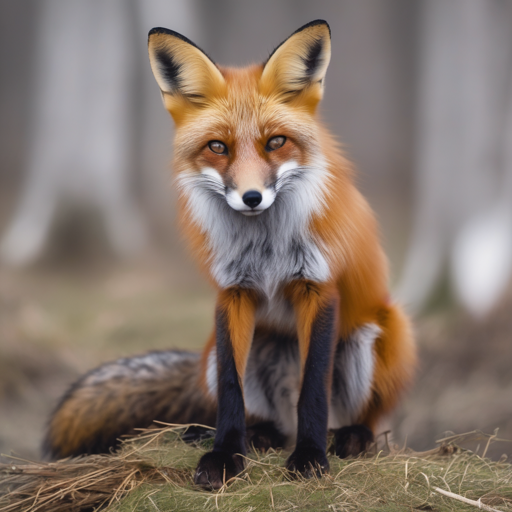

In [ ]:
def load_image_k(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(device)
    return image

source_prompt = ""
ref_prompt = ""
target_prompt = "A fox is in the bowl"
num_inference_steps = 50

# ref image
REF_IMAGE_PATH = "data/image5.png"
ref_image = load_image_k(REF_IMAGE_PATH, device)

# invert the source image
ref_start_code, ref_latents_list = sd_model.invert(ref_image,
                                        ref_prompt,
                                        guidance_scale=7.5,
                                        num_inference_steps=num_inference_steps,
                                        return_intermediates=True)

pil_image = transforms.ToPILImage()(read_image(REF_IMAGE_PATH))
pil_image.resize((512,512))

input text embeddings : torch.Size([1, 77, 768])
latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 12.79it/s]


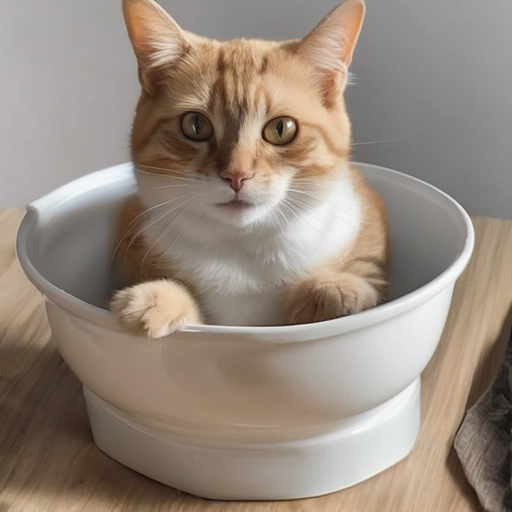

In [ ]:
# source image
SOURCE_IMAGE_PATH = "data/image4.png"
source_image = load_image_k(SOURCE_IMAGE_PATH, device)

# results of direct synthesis
source_start_code, source_latents_list = sd_model.invert(source_image,
                                            source_prompt,
                                            guidance_scale=7.5,
                                            num_inference_steps=num_inference_steps,
                                            return_intermediates=True)

pil_image = transforms.ToPILImage()(read_image(SOURCE_IMAGE_PATH))
pil_image.resize((512,512))

## run grounded sam

In [ ]:
args = SLConfig.fromfile('HuggingFace/Shilongliu/GroundingDINO/GroundingDINO_SwinB.cfg.py') 
groundingdino_model = build_model(args)
checkpoint = torch.load('HuggingFace/Shilongliu/GroundingDINO/groundingdino_swinb_cogcoor.pth', map_location='cpu')
groundingdino_model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
groundingdino_model.eval()

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=DEVICE)
sam_predictor = SamPredictor(sam)

final text_encoder_type: bert-base-uncased


In [11]:
def load_image(image):
    transform = T.Compose(
        [
            T.RandomResize([400], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_transformed, _ = transform(image, None)
    return image_transformed

TEXT_PROMPT1 = "cat"  #source
TEXT_PROMPT2 = "fox"  #ref
BOX_TRESHOLD = 0.3
TEXT_TRESHOLD = 0.25

source_image_np = np.asarray(source_image.squeeze().cpu())
source_image_np = source_image_np.transpose(1,2,0)
source_image_np = (source_image_np * 0.5 + 0.5) * 255
source_image_I = Image.fromarray(np.uint8(source_image_np))
ref_image_np = np.asarray(ref_image.squeeze().cpu())
ref_image_np = ref_image_np.transpose(1,2,0)
ref_image_np = (ref_image_np * 0.5 + 0.5) * 255
ref_image_I = Image.fromarray(np.uint8(ref_image_np))

trans_source = load_image(source_image_I)
trans_ref = load_image(ref_image_I)

source_boxes, source_logits, source_phrases = predict(
    model=groundingdino_model, 
    image=trans_source, 
    caption=TEXT_PROMPT2, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD,
    device=DEVICE
)
ref_boxes, ref_logits, ref_phrases = predict(
    model=groundingdino_model, 
    image=trans_ref, 
    caption=TEXT_PROMPT1, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD,
    device=DEVICE
)

source_annotated_frame = annotate(image_source=source_image_np, boxes=source_boxes, logits=source_logits, phrases=source_phrases)
source_annotated_frame = source_annotated_frame[...,::-1] # BGR to RGB
ref_annotated_frame = annotate(image_source=ref_image_np, boxes=ref_boxes, logits=ref_logits, phrases=ref_phrases)
ref_annotated_frame = ref_annotated_frame[...,::-1] # BGR to RGB

sam_predictor.set_image(np.uint8(source_image_np))
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = source_image_np.shape
source_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(source_boxes) * torch.Tensor([W, H, W, H])
source_transformed_boxes = sam_predictor.transform.apply_boxes_torch(source_boxes_xyxy, source_image_np.shape[:2]).to(DEVICE)
source_masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = source_transformed_boxes,
            multimask_output = False,
        )
sam_predictor.set_image(np.uint8(ref_image_np))
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = ref_image_np.shape
ref_boxes_xyxy = box_ops.box_cxcywh_to_xyxy(ref_boxes) * torch.Tensor([W, H, W, H])
ref_transformed_boxes = sam_predictor.transform.apply_boxes_torch(ref_boxes_xyxy, ref_image_np.shape[:2]).to(DEVICE)
ref_masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = ref_transformed_boxes,
            multimask_output = False,
        )

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


In [12]:
def expand_mask(mask, dalite_kernel):

    expanded_mask = cv2.dilate(np.uint8(mask), dalite_kernel, iterations=5)
    
    # 将扩张后的掩码转换回二维
    return torch.Tensor(expanded_mask).to(gpu_device)
    
source_mask = torch.where(source_masks[0][0], 1, 0)
ref_mask = torch.where(ref_masks[0][0], 1, 0)

gpu_device = ref_mask.device
kernel=np.ones((3,3),np.uint8)
source_mask = expand_mask(source_mask.detach().cpu().numpy(), kernel)

## inference the synthesized image

AttentionAdd_yh at denoising steps:  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
AttentionAdd_yh at U-Net layers:  [9, 10, 11, 12, 13, 14, 15]
input text embeddings : torch.Size([3, 77, 768])
latents shape:  torch.Size([3, 4, 64, 64])


DDIM Sampler: 100%|██████████| 50/50 [00:18<00:00,  2.70it/s]


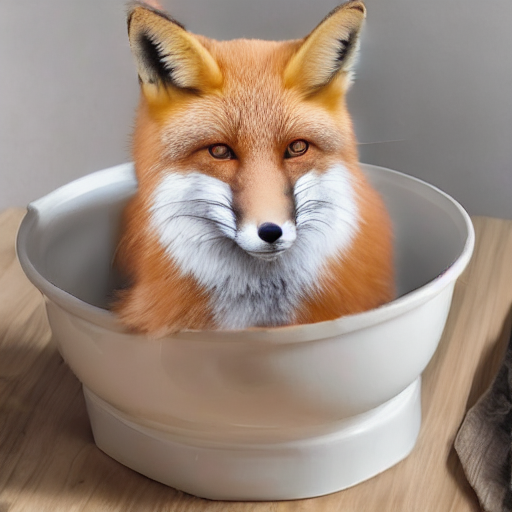

In [ ]:
lbl = LocalBlend(source_mask.float())
self_replace_steps = 0.1
cross_replace_steps = {'default_': .0,}
SAQI_st = 0
START_LAYPER = 9
END_LAYPER = 16
START_STEP = 4
END_STEP = 50
prompts = ['a photo of a cat', 'a photo of a fox', target_prompt]
ref_start_code = ref_start_code.expand(len(prompts), -1, -1, -1)
source_start_code = source_start_code.expand(len(prompts), -1, -1, -1)
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

editor = McaControlReplace(prompts, tokenizer, [0,1,2,3], self_replace_steps, START_STEP, END_STEP, START_LAYPER, END_LAYPER, mask_s=ref_mask.float(), mask_t=source_mask.float())
regiter_attention_editor_diffusers(sd_model, editor)

image_mcactrl = sd_model(prompts,
                    latents=source_start_code,
                    num_inference_steps=num_inference_steps,
                    guidance_scale=7.5,
                    ref_intermediate_latents=[ref_latents_list, source_latents_list],
                    lbl = lbl,
                    neg_prompt = negative_prompt,
                    mask_r = ref_mask.float(),
                    mask_t = source_mask.float())

pil_image = transforms.ToPILImage()(image_mcactrl[-1:].squeeze())
pil_image